In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [2]:
df_ind = pd.read_csv('india.csv')

In [3]:
def gaussian_distribution(x, std, mean):
    return (1/(std*math.sqrt(2*math.pi)))*math.exp((-1/2)*((x-mean)/std)**2)

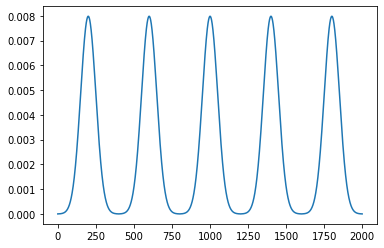

In [4]:
# Here we have assumed a wave will get over in 4 * std amount of time, since we assumed a wave
# will be over in 200 days we have considered 50 as std
gdist = [gaussian_distribution(i, 50, 200) for i in range(0, 400)]

gdist = np.concatenate((gdist, gdist, gdist, gdist, gdist))

plt.plot(gdist)
df = np.array(gdist)

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(df.reshape(-1, 1)) #reshape for (n, ) to (n, 1)


look_back = 50
prediction_days = 500

x_train, y_train = [], []

for x in range(look_back, len(scaled_data) - prediction_days):
  x_train.append(scaled_data[x - look_back: x, 0])
  y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [6]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))  #our predictions
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [7]:
model.fit(x_train, y_train, epochs = 5, batch_size = 32)

Epoch 1/5
46/46 [==============================] - 12s 128ms/step - loss: 0.0250
Epoch 2/5
46/46 [==============================] - 6s 123ms/step - loss: 0.0062
Epoch 3/5
46/46 [==============================] - 6s 128ms/step - loss: 0.0030
Epoch 4/5
46/46 [==============================] - 6s 128ms/step - loss: 0.0027
Epoch 5/5
46/46 [==============================] - 6s 126ms/step - loss: 0.0028


In [8]:
last = x_train[len(scaled_data) - prediction_days - look_back - 1]
x_test = np.array([last])
ys = []
for i in range(0, prediction_days):
    ysi = model.predict(x_test)[0]
    ys.append(np.array([max(0, ysi[0])]))
    x_test = np.array([np.concatenate((last[1:], [ys[-1]]))])
    last = x_test[0]

In [9]:
predicted_cases = scaler.inverse_transform(ys)
pred = np.concatenate((df[:len(scaled_data)-prediction_days], predicted_cases.reshape(-1,)))

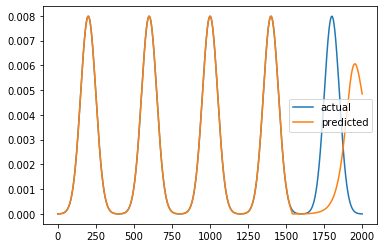

In [11]:
plt.figure()
plt.plot(df, label="actual")
plt.plot(pred, label="predicted")
plt.legend()